## Separa os dados em treino e teste, treina os modelos, faz os testes, verifica os resultados e escolhe o modelo que ficou com os resultados de suas métricas mais adequados

In [1]:
# importa bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import tree
from sklearn.metrics import r2_score
from sklearn import svm
import joblib
from fc import fc_download_s3 as ds3
from fc import fc_upload_s3 as ups3
import os

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import warnings
warnings.simplefilter('ignore')

## Le arquivos do repositório na nuvem

In [2]:
# ******************** INICIALIZA VARIÁVEIS DO REPOSITÓRIO DE DADOS
dir_dados = 'arquivos'
dir_dados_tratados = 'arquivos_tratados'
dir_modelos = 'modelos'
dir_par = 'parametros'
dir_S3 = 'vendas-supermarket-s3'
dir_S3_tratados = 'vendas-supermarket-s3-tratados'
dir_S3_modelos = 'vendas-supermarket-s3-modelos'
arq_dados = 'supermarket_sales.csv'
arq_dados_tratados = 'df_supermarket_sales.csv' 
arq_keys = 'parametros/chaves_acesso.txt'
barra = '/'

if os.path.exists(dir_dados) == False:
    try:
        os.mkdir(dir_dados)
    finally:
        fim = 'ok'

In [3]:
# ******************** LE O ARQUIVO DE CHAVES
arq_par = open(arq_keys,'r')

access_key = arq_par.readline()
access_key = access_key[0:len(access_key) -1]

secret_key = arq_par.readline()
secret_key = secret_key[0:len(secret_key) -1]

regiao = arq_par.readline()
arq_par.close()  

In [4]:

# ******************** CHAMA A FUNÇÃO DE DOWNLOAD DO BUCKET S3 para baixar os arquivos tratados
retorno = 'ok'
''' **************** comentado para que o kernel não trave se não existir um bucket s3 criado
retorno = ds3.download_s3(
            dir_S3_tratados, 
            arq_dados_tratados, 
            dir_dados_tratados + barra + arq_dados_tratados, 
            access_key, secret_key, regiao)
'''

if retorno != 'ok':
    print(retorno)
    print('bucket s3 => ' + dir_S3_tratados + ' arquivo => ' + arq_dados_tratados + 
            ' ***** não foi baixado')
    exit()


In [5]:
# le os dados do dataset recebendo em formato de dataframe
dfx = pd.read_csv('arquivos_tratados/df_supermarket_sales.csv')

In [6]:
# verificando se todos os dados foram carregados
# 1000 linhas e 24 colunas, ok!
dfx.shape

(1000, 27)

In [7]:
# verifica os dados
# verificando que as colunas categoricas foram mantidas e novas colunas numericas de dados categóricos foram criadas, ok!
dfx.head(3)

,id_fatura,filial,cidade,tipo_cliente,genero,linha_produto,preco_unitario,qtde,imposto,total_preco,moeda,custo,margem_bruta,receita_bruta,experiencia_cliente,data_hora,dia_semana,dia,mes,ano,feriado,hora,filial_nro,tipo_cliente_nro,genero_nro,linha_produto_nro,moeda_nro
0,765-26-6951,A,Yangon,Normal,Male,Sports and travel,72.61,6,21.783,457.443,Credit card,435.66,4.761905,21.783,6.9,2019-01-01 10:39:00,1,1,1,2019,0,10,0,1,1,5,1
1,746-04-1077,B,Mandalay,Member,Female,Food and beverages,84.63,10,42.315,888.615,Credit card,846.30,4.761905,42.315,9.0,2019-01-01 11:36:00,1,1,1,2019,0,11,1,0,0,2,1
2,271-77-8740,C,Naypyitaw,Member,Female,Sports and travel,29.22,6,8.766,184.086,Ewallet,175.32,4.761905,8.766,5.0,2019-01-01 11:40:00,1,1,1,2019,0,11,2,0,0,5,2


In [8]:
# verifica os dados gerados no agrupamento
display(dfx.info())
display(dfx.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id_fatura            1000 non-null   object 
 1   filial               1000 non-null   object 
 2   cidade               1000 non-null   object 
 3   tipo_cliente         1000 non-null   object 
 4   genero               1000 non-null   object 
 5   linha_produto        1000 non-null   object 
 6   preco_unitario       1000 non-null   float64
 7   qtde                 1000 non-null   int64  
 8   imposto              1000 non-null   float64
 9   total_preco          1000 non-null   float64
 10  moeda                1000 non-null   object 
 11  custo                1000 non-null   float64
 12  margem_bruta         1000 non-null   float64
 13  receita_bruta        1000 non-null   float64
 14  experiencia_cliente  1000 non-null   float64
 15  data_hora            1000 non-null   ob

None

,id_fatura,filial,cidade,tipo_cliente,genero,linha_produto,preco_unitario,qtde,imposto,total_preco,moeda,custo,margem_bruta,receita_bruta,experiencia_cliente,data_hora,dia_semana,dia,mes,ano,feriado,hora,filial_nro,tipo_cliente_nro,genero_nro,linha_produto_nro,moeda_nro
0,765-26-6951,A,Yangon,Normal,Male,Sports and travel,72.61,6,21.783,457.443,Credit card,435.66,4.761905,21.783,6.9,2019-01-01 10:39:00,1,1,1,2019,0,10,0,1,1,5,1
1,746-04-1077,B,Mandalay,Member,Female,Food and beverages,84.63,10,42.315,888.615,Credit card,846.30,4.761905,42.315,9.0,2019-01-01 11:36:00,1,1,1,2019,0,11,1,0,0,2,1
2,271-77-8740,C,Naypyitaw,Member,Female,Sports and travel,29.22,6,8.766,184.086,Ewallet,175.32,4.761905,8.766,5.0,2019-01-01 11:40:00,1,1,1,2019,0,11,2,0,0,5,2
3,133-14-7229,C,Naypyitaw,Normal,Male,Health and beauty,62.87,2,6.287,132.027,Cash,125.74,4.761905,6.287,5.0,2019-01-01 11:43:00,1,1,1,2019,0,11,2,1,1,3,0
4,651-88-7328,A,Yangon,Normal,Female,Fashion accessories,65.74,9,29.583,621.243,Cash,591.66,4.761905,29.583,7.7,2019-01-01 13:55:00,1,1,1,2019,0,13,0,1,0,1,0


In [9]:
# separa as variáveis: dependente_y x independentes_x
# as variáveis independentes (x) são separadas da variável dependente (y) em dataframes diferentes

#X = dfx[['preco_unitario', 'custo', 'imposto','dia_semana', 'feriado', 'tipo_cliente_nro', \
#         'genero_nro', 'linha_produto_nro', 'moeda_nro']]

X = dfx[['linha_produto_nro', 'mes', 'dia', 'preco_unitario', 'custo', 'dia_semana', 'feriado',]]
y = dfx[['qtde']]

In [10]:
# verifica o Dtype das variáveis independentes
print('X', X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   linha_produto_nro  1000 non-null   int64  
 1   mes                1000 non-null   int64  
 2   dia                1000 non-null   int64  
 3   preco_unitario     1000 non-null   float64
 4   custo              1000 non-null   float64
 5   dia_semana         1000 non-null   int64  
 6   feriado            1000 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 54.8 KB
X None


In [11]:
# separa dados de treino e de teste
# aplica-se a função train_test_split para separar com IA 20% para o teste e 80 para o treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, train_size=0.80, random_state=42)

In [12]:
# verifica o Dtype das variáveis de teste
print('x_test', X_test.info())
print('y_test', y_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 521 to 78
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   linha_produto_nro  200 non-null    int64  
 1   mes                200 non-null    int64  
 2   dia                200 non-null    int64  
 3   preco_unitario     200 non-null    float64
 4   custo              200 non-null    float64
 5   dia_semana         200 non-null    int64  
 6   feriado            200 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 12.5 KB
x_test None
<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 521 to 78
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   qtde    200 non-null    int64
dtypes: int64(1)
memory usage: 3.1 KB
y_test None


## Regressão Linear Múltipla

In [13]:
# treina e prediz quantidade de venda
# aqui treina o modelo LinearRegression com X_train e y_train e faz a predição com X_test
rlm_model = LinearRegression().fit(X_train, y_train)
y_pred = rlm_model.predict(X_test)

In [14]:
# Avalia o modelo
# na avaliação do modelo vemos que os 2 scores estão satisfatórios acima de 70% (o máximo é 1 ou 100%)
# na avaliação dos erros médio e quadrático temos valores altos, o que não é bom, o ideal é que o erro seja pequeno
# o erro é a diferença entre os dados esperados encontrado no teste e os dados previstos encontrados na predição
# o erro quadrático é o desvio padrão da diferença entre os dados
print('coeficiente de determinação (score)', rlm_model.score(X_train, y_train))
print('coeficiente de determinação r2_score', r2_score(y_test, y_pred))
print('erro médio absoluto', mean_absolute_error(y_test, y_pred))
print('erro quadrático médio', mean_squared_error(y_test,y_pred))

coeficiente de determinação (score) 0.8205602931891831
coeficiente de determinação r2_score 0.7966923635707228
erro médio absoluto 0.9364497054980725
erro quadrático médio 1.6629293987187186


## Árvore de Regressão

In [15]:
# Cria o regressor da árvore de decisão usando tree.DeciisionTreeRegressor (outro modelo do scikit learn)
regTree = tree.DecisionTreeRegressor(random_state=2)

In [16]:
# Faz o fit, treina o modelo
# aqui treina o modelo com os dados de treino X_train e com os dados de teste y_train
Dtree_model = regTree.fit(X_train, y_train)

In [17]:
# Faz um predict(predição) e avalia o modelo
# Na avaliação do modelo utilizando os dados de teste e os dados da predição vemos que os scores ficaram satisfatoriamente
# altos, próximo a 1 ou 100% e os erros absoluto e quadrático ficaram bem próximo de zero o que é excelente
y_predTree = Dtree_model.predict(X_test)

print('coeficiente de determinação (score)', Dtree_model.score(X_test, y_test))
print('coeficiente de determinação r2_score', r2_score(y_test, y_predTree))
print('erro médio absoluto', mean_absolute_error(y_test, y_predTree))
print('erro médio quadrático', mean_squared_error(y_test,y_predTree)) 

coeficiente de determinação (score) 0.9749369603423245
coeficiente de determinação r2_score 0.9749369603423245
erro médio absoluto 0.195
erro médio quadrático 0.205


## SVR

In [18]:
# Cria o regressor do modelo SVM(Support Vector Machine) SVR (Support Vector Regression)
regSVR = svm.SVR()

In [19]:
# Faz o fit, treina o modelo
# o modelo é treinado com os dados de treino (X_train e y_train)
SVR_model = regSVR.fit(X_train, y_train)

In [20]:
# Faz a predição dos valores e avalia o modelo
# os scores estão satisfatórios acima de 80% (o máximo é 1 ou 100%)
# na avaliação dos erros médio e quadrático temos valores altos, o que não é bom, o ideal é que o erro seja pequeno
y_predSVR = SVR_model.predict(X_test)

print('coeficiente de determinação (score)', regSVR.score(X_test, y_test))
print('coeficiente de determinação r2_score', r2_score(y_test, y_predSVR, multioutput='variance_weighted'))
print('erro médio absoluto', mean_absolute_error(y_test, y_predSVR))
print('erro médio quadrático', mean_squared_error(y_test,y_predSVR))

coeficiente de determinação (score) 0.8364062342459189
coeficiente de determinação r2_score 0.8364062342459189
erro médio absoluto 0.7490828034338156
erro médio quadrático 1.3380947577647873


## Visualiza as Informações

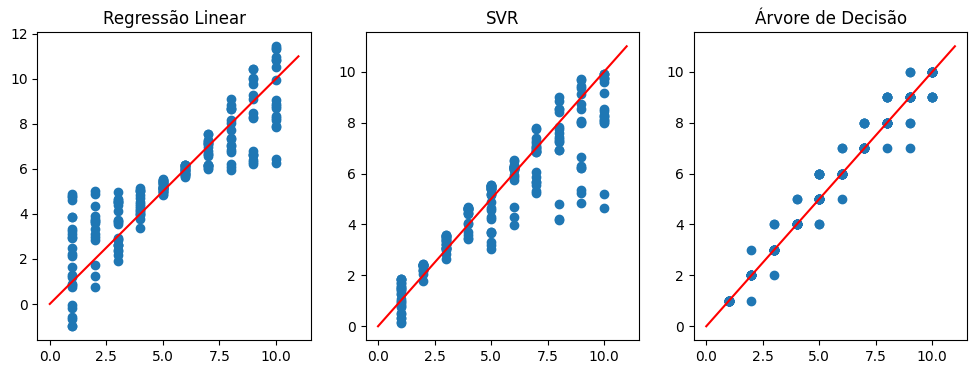

In [21]:
# Plota gráficos de regressão linear dos testes
# aqui é feito uma avaliação na dispersão dos dados de previstos com os dados de teste fazendo uma regressão linear
# observamos que o gráfico que ficou com uma melhor distribuição com a menor dispersão foi do modelo de árvore de deicsão
# isso confirma os resultados dos scores e do erro médio absoluto e erro médio quadrático analisados anteriormente
# então o melhor modelo avaliado foi o de árvore de regressão, sendo assim esse modelo será o adotado para ser usado
# nas novas predições que serão utilizadas oficialmente na avaliação de vendas de mercadorias
import numpy as np
fig,ax = plt.subplots(ncols=3,figsize=(12,4))

x = np.arange(0,12)
y = x
ax[0].scatter(y_test,y_pred)
ax[0].plot(x,y,'r')
ax[0].set_title('Regressão Linear')

ax[1].scatter(y_test,y_predSVR)
ax[1].plot(x,y,'r')
ax[1].set_title('SVR')

ax[2].scatter(y_test,y_predTree)
ax[2].plot(x,y,'r')
ax[2].set_title('Árvore de Decisão')

plt.show()

In [22]:
# salva os dados das variáveis independentes para fazer predição
X2 = dfx[['linha_produto', 'linha_produto_nro', 'ano', 'mes', 'dia', 'preco_unitario', 'custo', 
          'dia_semana', 'feriado', 'qtde']]
X2.sort_values(by=['ano', 'mes', 'dia']).to_csv('arquivos_tratados/X_supermarket_sales.csv', index=False)

In [23]:
# salva o modelo de árvore de decisão (faz o deploy)
# o modelo treinado e aprovado, agora é salvo em um arquivo pkl para ser utilizado em futuras aplicações
joblib.dump(Dtree_model, "modelos/dtree_model_vendasSupermarket.pkl")

['modelos/dtree_model_vendasSupermarket.pkl']

## Upload de arquivos no repositório da nuvem aws

In [24]:
# Upload de arquivo no repositório da nuvem aws
# salva os dados das variáveis independentes para fazer predição
arq_predicao = 'X_supermarket_sales.csv'

retorno = 'ok'
''' **************** comentado para que o kernel não trave se não existir um bucket s3 criado
retorno = ups3.upload_s3(
            dir_S3_tratados, 
            arq_predicao, 
            dir_dados_tratados + barra + arq_predicao, 
            access_key, secret_key, regiao)
'''

if retorno != 'ok':
    print(retorno)
    print('bucket s3 => ' + dir_S3_tratados + ' arquivo => ' + arq_predicao + 
            ' ***** não foi carregado')
    exit()

In [25]:
# Upload de arquivo no repositório da nuvem aws
# o modelo gerado(deploy) e salvo em pasta anteriormente agora será carregado para um buket na nuvem da aws
# podendo ser capturado por qualquer aplicação que tiver acesso ao bucket
arq_modelos = 'dtree_model_vendasSupermarket.pkl'

retorno = 'ok'
''' **************** comentado para que o kernel não trave se não existir um bucket s3 criado
retorno = ups3.upload_s3(
            dir_S3_modelos, 
            arq_modelos, 
            dir_modelos + barra + arq_modelos, 
            access_key, secret_key, regiao)
'''

if retorno != 'ok':
    print(retorno)
    print('bucket s3 => ' + dir_S3_modelos + ' arquivo => ' + arq_modelos + 
            ' ***** não foi carregado')
    exit()